## Data loading

In the last exercises, we took care of the dataloading and mini-batching for you. With PyTorch, this task is considerably easier, so let's do it ourselves.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [2]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(<PIL.Image.Image image mode=L size=28x28 at 0x7F8D10064760>, 5)


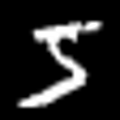

In [3]:
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0), (1.0))
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a torch tensor

In [ ]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [5]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [6]:
#########################################################################
# Task #1: Calculate the mean and std of MNIST
# https://pytorch.org/docs/stable/
#########################################################################
mu = ims_train.mean()
std = ims_train.std()


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 2 workers (number of subprocess that peform the dataloading. Important: you need to shuffle the training data, not the test data.

In [8]:
#########################################################################
# Task #2: Build a dataloader for both train and test data.
#########################################################################
dl_train = DataLoader(ds_train, batch_size=64, num_workers=2, shuffle=True)
dl_test = DataLoader(ds_train, batch_size=64, num_workers=2, shuffle=False)


## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises.

In [9]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 1
nHidden = 64
act_fn = nn.ReLU()

In [10]:
#########################################################################
# Task #3: Implement the __init__ of the MLP class. 
# insert the activation after every linear layer. Important: the number of 
# hidden layers should be variable!
#########################################################################

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [] 
        
        ##### implement this part #####
        layers += [nn.Flatten(), nn.Linear(nInput, nHidden)]
        layers += [act_fn]
        for i in range(nLayer):
          layers += [nn.Linear(nHidden, nHidden)]
          layers += [act_fn]
        layers += [nn.Linear(nHidden, nOutput)]

        
        ###############################
        
        layers += [nn.LogSoftmax(dim=1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # x = torch.flatten(x, 1)
        return self.model(x)

In [11]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [12]:
# Task 4: Define the device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We already implemented the test function for you

In [13]:
def test(model, dl_test, device=device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now we only need to implement the training and we are good to go

In [14]:
#########################################################################
# Task #5: Implement the missing part of the training function. As a loss function we want to use cross-entropy
# The model already has a Log-softmax as the last layer, hence, we only need to apply the 
# negative log likelihood loss. It can be called with F.nll_loss().
#########################################################################

def train(model, dl_train, optimizer, epoch, log_interval=100, device=device):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()         
        
        ##### IMPLEMENT HERE #####
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        ##########################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

In [15]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp.to(device)
# Task 6: Define the optimizer here
learning_rate = 1e-3
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

In [ ]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296591
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.299910
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.372370
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.218719
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.317251
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.343535
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.171619
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.116833
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.197070
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.093936

Train set: Average loss: 0.2440, Accuracy: 54546/60000 (90.9%)


Test set: Average loss: 0.1489, Accuracy: 57269/60000 (95.448%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.195249
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.115550
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.077137
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.272793
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.063743
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.129051
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.060100
Train Epoch: 2 [44800/60000 (75

KeyboardInterrupt: ignored

After training, you should see test accuracies of > 97% - this is the performance we saw in our last experiments with EDF. By they way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

## CNN in PyTorch
Alright, we matched our prior performance. Let's surpass it!
We will build a small CNN. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|
| Log softmax (see above in MLP definition)    	|

The layers you will need are: 

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.LogSoftmax, nn.Flatten`

For layers with out parameters you can alternatively use function in the forward pass:  

`F.max_pool2d, torch.flatten, F.log_softmax`

In [16]:
#########################################################################
#Task 8: Implement the __init__ and forward method of the CNN class. 
# Hint: do not forget to flatten the appropriate dimension after the convolutional blocks. 
# A linear layers expect input of the size (B, H) with batch size B and feature size H
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)



    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output



In [17]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape
cnn.to(device)

learning_rate = 1e-3
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Alright, let's train!

In [20]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323251
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.379432
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.333166
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.076658
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.364257
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.150111
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.112840
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.123298
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.041727
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.068114

Train set: Average loss: 0.1859, Accuracy: 56575/60000 (94.3%)


Test set: Average loss: 0.0414, Accuracy: 59274/60000 (98.790%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.031182
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.024869
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.071152
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.035943
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.238597
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.041168
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.161775
Train Epoch: 2 [44800/60000 (75